In [240]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

In [173]:
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [203]:
A300 = pd.read_excel('A300_daily.xls').dropna()
A500 = pd.read_excel('A500_daily.xls').dropna()
SPX = pd.read_excel('SPX_daily.xls').dropna()
HSI = pd.read_excel('HSI_daily.xls').dropna()

AU9999 = pd.read_excel('AU9999_daily.xls').dropna()

indices = {'A300':A300, 'A500':A500, 'SPX':SPX, 'HSI':HSI, 'AU9999':AU9999}

# 清洗数据
for name, index in indices.items():
    index = index.dropna()
    index = index[(index['交易时间'] >= '2008-01-01') & (index['交易时间'] <= '2023-01-01')]
    index = index.reset_index(drop=True)
    indices[name] = index   

#同步时间序列，直接删除不同市场区域不匹配的交易时间
for index, row in indices['A300'].iterrows():
    if(indices['HSI']['交易时间'] == row['交易时间']).sum() == 0:
        indices['A300'].drop(index = index, inplace = True)
        indices['A500'].drop(index = index, inplace = True)
        indices['AU9999'].drop(index = index, inplace = True)
    if(indices['SPX']['交易时间'] == row['交易时间']).sum() == 0:
        if index in indices['A300'].index.values:
            indices['A300'].drop(index = index, inplace = True)
        if index in indices['A500'].index.values:
            indices['A500'].drop(index = index, inplace = True)
        if index in indices['AU9999'].index.values:
            indices['AU9999'].drop(index = index, inplace = True)

for index, row in indices['SPX'].iterrows():
    if(indices['HSI']['交易时间'] == row['交易时间']).sum() == 0:
        indices['SPX'].drop(index = index, inplace = True)
    if(indices['A300']['交易时间'] == row['交易时间']).sum() == 0:
        if index in indices['SPX'].index.values:
            indices['SPX'].drop(index = index, inplace = True)

for index, row in indices['HSI'].iterrows():
    if(indices['SPX']['交易时间'] == row['交易时间']).sum() == 0:
        indices['HSI'].drop(index = index, inplace = True)
    if(indices['A300']['交易时间'] == row['交易时间']).sum() == 0:
        if index in indices['HSI'].index.values:
            indices['HSI'].drop(index = index, inplace = True)

for name, index in indices.items():
    index.reset_index(drop=True, inplace=True)

In [204]:
# 确保不同区域市场时间序列大小一致
print(indices['A500'].shape[0])
print(indices['HSI'].shape[0])
print(indices['SPX'].shape[0])

3460
3460
3460


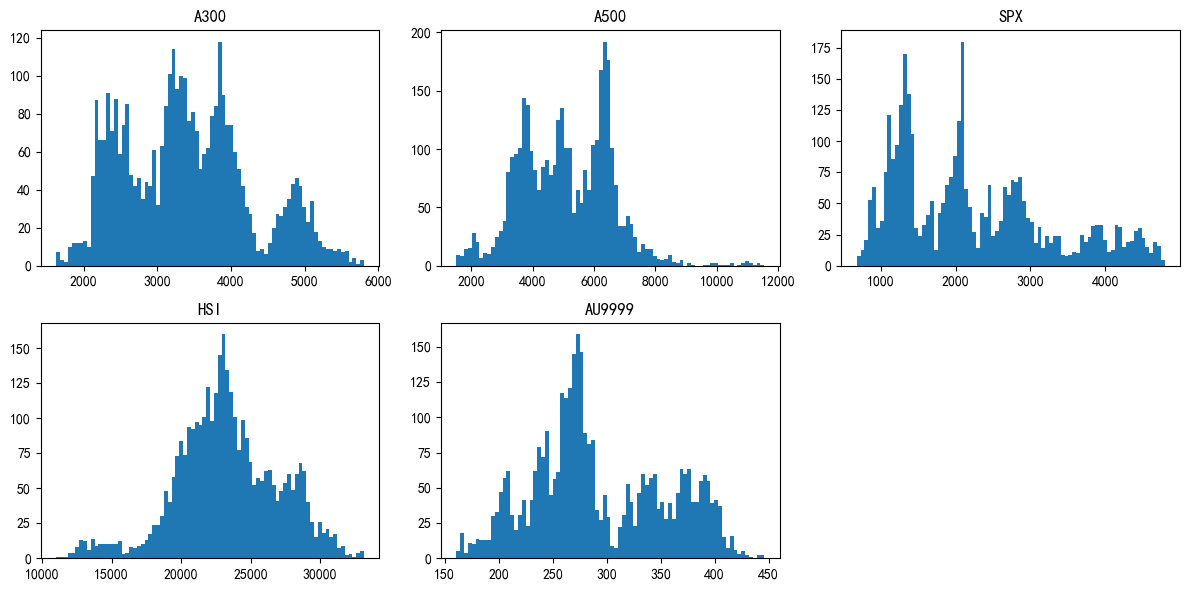

In [238]:
# 分布直方图

fig = plt.figure(figsize=(12, 6))
i = 1
for name, index in indices.items():
    ax = plt.subplot(2, 3, i)
    ax.set_title(name)
    plt.tight_layout()
    plt.hist(np.array(index['收盘价']), bins=80)
    i += 1

In [228]:
np.array(index['收盘价'])

array([196.46, 200.8 , 202.5 , ..., 408.99, 407.19, 410.49])

In [206]:
prices = np.array([[0] * 3460])
names = []
for name, index in indices.items():
    print(name, end=' ')
    names.append(name)
    prices = np.r_[prices, np.array(index['收盘价']).reshape(1,-1)]
prices = prices[1:].T

A300 A500 SPX HSI AU9999 

In [208]:
# 计算期望与协方差

Mu = prices.mean(axis = 0).reshape(-1, 1)
Cov = np.cov(prices.T)
pd.DataFrame(np.corrcoef(prices.T), columns=names, index=names)   # 相关系数

,A300,A500,SPX,HSI,AU9999
A300,1.000000,0.788076,0.743082,0.593845,0.451829
A500,0.788076,1.000000,0.649532,0.523523,0.322699
SPX,0.743082,0.649532,1.000000,0.499714,0.669524
HSI,0.593845,0.523523,0.499714,1.000000,0.196278
AU9999,0.451829,0.322699,0.669524,0.196278,1.000000


In [256]:
Cov[0][0]

746792.5560128344

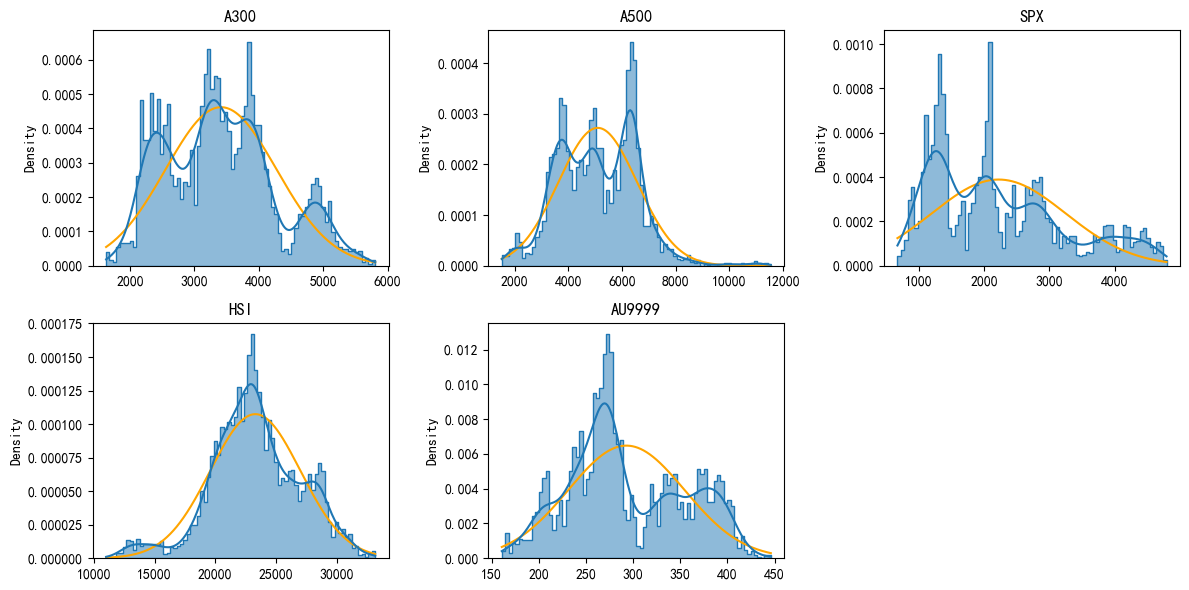

In [277]:
# 分布图

fig = plt.figure(figsize=(12, 6))
i = 0
for name, index in indices.items():
    ax = plt.subplot(2, 3, i + 1)
    ax.set_title(name)
    plt.tight_layout()
    price = np.array(index['收盘价'])
    norm_x = np.linspace(price.min(), price.max(), 100000)
    norm_y = scipy.stats.norm.pdf(norm_x, Mu[i], np.sqrt(Cov[i,i]))
    plt.plot(norm_x,norm_y,c="orange")
    sns.histplot(data = price, bins = 80, kde=True, ax = ax, element="step", stat="density")
    i += 1